#### Source: https://www.kaggle.com/osmi/mental-health-in-tech-survey

# Dataset Information
This dataset is from a 2014 survey that measures attitudes towards mental health and frequency of mental health disorders in the tech workplace. You are also encouraged to analyze data from the ongoing 2016 survey found here.

#### Content
This dataset contains the following data:

Timestamp

Age

Gender

Country

state: If you live in the United States, which state or territory do you live in?

self_employed: Are you self-employed?

family_history: Do you have a family history of mental illness?

treatment: Have you sought treatment for a mental health condition?

work_interfere: If you have a mental health condition, do you feel that it interferes with your work?

no_employees: How many employees does your company or organization have?

remote_work: Do you work remotely (outside of an office) at least 50% of the time?

tech_company: Is your employer primarily a tech company/organization?

benefits: Does your employer provide mental health benefits?

care_options: Do you know the options for mental health care your employer provides?

wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?

seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?

anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?

leave: How easy is it for you to take medical leave for a mental health condition?

mentalhealthconsequence: Do you think that discussing a mental health issue with your employer would have negative consequences?

physhealthconsequence: Do you think that discussing a physical health issue with your employer would have negative consequences?

coworkers: Would you be willing to discuss a mental health issue with your coworkers?

supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?

mentalhealthinterview: Would you bring up a mental health issue with a potential employer in an interview?

physhealthinterview: Would you bring up a physical health issue with a potential employer in an interview?

mentalvsphysical: Do you feel that your employer takes mental health as seriously as physical health?

obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?



#### Variable of Interest (Target Variable)
Treatment: Have you sought treatment in the past for mental health

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


cc_df = pd.read_csv('survey.csv')
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
949,2014-08-29 00:43:37,40,Male,United States,WA,No,Yes,Yes,Sometimes,6-25,...,Very easy,Maybe,No,Some of them,Some of them,No,No,Don't know,No,NaN
854,2014-08-28 17:01:06,31,Male,United States,NaN,No,Yes,No,NaN,6-25,...,Don't know,Maybe,No,Some of them,Some of them,No,No,Don't know,No,NaN
658,2014-08-28 04:37:54,30,M,United Kingdom,NaN,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Maybe,No,Some of them,Yes,No,Yes,Yes,No,NaN
1213,2015-02-21 09:19:12,31,Male,Philippines,NaN,No,No,No,Sometimes,More than 1000,...,Very difficult,Yes,Yes,Some of them,No,No,Maybe,No,Yes,NaN
439,2014-08-27 15:43:27,29,Male,United States,PA,No,Yes,Yes,Rarely,1-5,...,Somewhat easy,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2014-08-27 12:31:43,18,Male,United States,CT,No,No,Yes,Rarely,1-5,...,Very easy,No,No,Some of them,No,No,No,Don't know,No,NaN
681,2014-08-28 08:43:58,38,Male,United States,MN,No,No,Yes,Sometimes,More than 1000,...,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,NaN
86,2014-08-27 12:07:08,39,Male,United Kingdom,NaN,Yes,No,Yes,Often,6-25,...,Very difficult,Maybe,No,Some of them,No,No,Maybe,No,Yes,NaN
724,2014-08-28 10:18:34,33,Male,United States,WY,No,Yes,Yes,Sometimes,1-5,...,Don't know,No,No,Some of them,Yes,Maybe,Maybe,Don't know,No,NaN


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 949 to 876
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  881 non-null    object
 1   Age                        881 non-null    int64 
 2   Gender                     881 non-null    object
 3   Country                    881 non-null    object
 4   state                      526 non-null    object
 5   self_employed              868 non-null    object
 6   family_history             881 non-null    object
 7   treatment                  881 non-null    object
 8   work_interfere             688 non-null    object
 9   no_employees               881 non-null    object
 10  remote_work                881 non-null    object
 11  tech_company               881 non-null    object
 12  benefits                   881 non-null    object
 13  care_options               881 non-null    object
 14  wellness

Findings: 
1. Some Columns like State,work_interfere,slef_employed and comments have null-Values.
2. Survey timestamp might not be required for later analysis since the object is non-related to time-series

# KEY Business Question
1. Predict prevalance of Mental Health Issue within organization
2. We want our True-Positive:Actual-Positive ratio to be high, therefore recall is our key matrix. This means:
- Given our business question, we do not want to miss out anywhere an issue of mental health exists
- If our prediction extends to somewhere where there isnt a mental health issue (Precision Trade-off), we do not mind. We just dont want to miss out on prospective mental health problem areas. In a way, we are screening (Recall priority)

In [4]:
from IPython.display import HTML  # This step is just to avoid the long columns being truncated as "..."

HTML(train_df.select_dtypes(object).apply(lambda x: pd.unique(x)).to_frame().to_html())

,0
Timestamp,"[2014-08-29 00:43:37, 2014-08-28 17:01:06, 2014-08-28 04:37:54, 2015-02-21 09:19:12, 2014-08-27 15:43:27, 2014-08-28 10:45:21, 2014-08-27 12:32:24, 2014-08-27 12:56:13, 2014-08-27 13:08:17, 2014-08-29 11:39:33, 2014-08-27 13:38:17, 2014-08-27 15:25:16, 2015-04-23 14:03:51, 2015-05-06 10:14:50, 2014-08-27 16:20:40, 2014-08-27 17:48:54, 2014-08-27 16:21:54, 2014-08-28 19:26:03, 2014-08-30 15:57:04, 2014-08-29 12:00:33, 2014-08-28 09:59:39, 2015-02-21 04:41:28, 2014-08-28 15:50:44, 2014-08-27 12:15:11, 2014-08-29 09:10:58, 2014-08-29 10:06:29, 2014-08-27 22:14:23, 2014-08-28 11:09:03, 2014-08-27 12:53:13, 2014-08-29 16:07:05, 2014-08-27 16:31:16, 2014-08-29 01:20:32, 2014-08-27 13:06:00, 2014-08-27 14:37:46, 2014-08-27 13:15:19, 2014-08-30 20:43:51, 2015-02-21 04:34:56, 2014-08-28 09:53:57, 2015-08-25 19:59:38, 2014-08-27 11:34:00, 2014-08-27 14:10:47, 2014-08-27 13:07:24, 2014-08-27 14:53:11, 2014-08-28 23:13:18, 2014-08-28 21:22:40, 2014-08-27 15:13:33, 2014-08-27 13:02:14, 2014-08-27 11:47:33, 2014-08-27 15:26:57, 2014-08-27 12:00:02, 2014-08-27 15:23:54, 2014-08-27 17:33:51, 2014-08-28 05:12:15, 2014-08-28 12:15:08, 2014-08-27 14:06:26, 2014-08-28 16:57:46, 2014-08-29 10:16:45, 2014-08-28 09:58:08, 2014-08-30 19:35:58, 2014-08-27 13:06:12, 2014-08-27 15:24:55, 2014-08-27 15:54:45, 2014-08-29 03:02:45, 2014-08-27 11:43:07, 2014-08-27 21:35:24, 2014-08-27 18:59:44, 2014-08-28 17:59:54, 2014-08-28 11:15:42, 2014-08-27 12:18:38, 2015-02-24 10:32:32, 2014-08-27 15:29:23, 2014-08-27 12:34:11, 2014-08-29 09:46:56, 2014-09-08 21:30:59, 2014-08-27 11:50:28, 2014-08-27 13:12:43, 2014-08-27 11:56:29, 2015-02-21 05:55:17, 2014-08-28 13:26:17, 2014-08-27 18:00:39, 2014-08-28 13:41:51, 2014-09-08 16:46:53, 2014-08-28 11:04:17, 2014-08-27 16:27:47, 2014-08-27 16:01:39, 2014-08-27 16:22:10, 2014-08-28 05:14:28, 2014-08-28 10:01:15, 2014-08-28 18:18:43, 2014-08-28 14:00:02, 2014-08-27 16:32:31, 2014-08-27 14:39:20, 2014-08-27 13:19:40, 2014-08-27 15:34:32, 2014-08-28 03:13:20, 2014-08-28 18:07:42, 2014-08-27 13:35:40, 2014-08-31 04:31:11, 2014-08-27 11:37:59, 2014-08-29 09:29:37, ...]"
Gender,"[Male, M, male, f, Female, something kinda male?, A little about you, female, F, m, Female , Mal, Enby, Female (cis), Cis Man, Femake, Trans-female, Androgyne, Neuter, ostensibly male, unsure what that really means, Nah, msle, non-binary, Male , Trans woman, Make, Agender, Man, Genderqueer, Woman, Guy (-ish) ^_^, Male-ish, male leaning androgynous, All, woman, p, Cis Male, Male (CIS), queer]"
Country,"[United States, United Kingdom, Philippines, Germany, Ireland, Australia, Israel, Sweden, Russia, Bahamas, The, Canada, Netherlands, South Africa, New Zealand, Austria, Portugal, France, Colombia, Japan, Bulgaria, Denmark, Italy, India, Bosnia and Herzegovina, Brazil, Greece, Croatia, Thailand, Belgium, Slovenia, Spain, Mexico, Hungary, Nigeria, Latvia, Finland, Norway, Czech Republic, Costa Rica, Poland, Switzerland, Singapore, Zimbabwe, Romania]"
state,"[WA, nan, PA, NY, CO, TN, MD, SC, FL, TX, IL, GA, CA, DC, MI, NM, UT, AZ, MO, MA, MN, OH, KY, VT, IN, CT, WI, OR, OK, WY, VA, RI, NC, WV, IA, KS, NJ, NH, AL, NV, SD, NE]"
self_employed,"[No, Yes, nan]"
family_history,"[Yes, No]"
treatment,"[Yes, No]"
work_interfere,"[Sometimes, nan, Rarely, Often, Never]"
no_employees,"[6-25, More than 1000, 1-5, 26-100, 500-1000, 100-500]"
remote_work,"[No, Yes]"


Findings:
1. Timestamp is to be ignored for now
2. Gender has a lot of data (No nulls) that requires preprocessing
3. State has nan value but we need to check whether these are non-US States or is the information missing from US as well
4. Self Employed data has to be imputed, also work_interfere
5. Need to check if other categories need to be collapsed to reduce categorical variable

In [5]:
train_df.describe(include=['object'])

,Timestamp,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,881,881,881,526,868,881,881,688,881,881,...,881,881,881,881,881,881,881,881,881,117
unique,874,39,44,41,2,2,2,4,6,2,...,5,3,3,3,3,3,3,3,2,114
top,2014-08-27 12:54:11,Male,United States,CA,No,No,No,Sometimes,26-100,No,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,440,531,92,762,534,442,318,203,619,...,391,343,658,539,357,690,391,401,757,4


In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train_df.select_dtypes(int).describe().round()

,Age
count,881.00
mean,113507408.00
std,3369085602.00
min,-1726.00
25%,27.00
50%,31.00
75%,36.00
max,99999999999.00


Findings:
1. Age has some negative values that will need to be imputed. Also the max values in Age also wrong. This is causing mean distortion
2. There is some text info in comments but not available for a majority of observations

# Basic Preporcessing of training and test data

- Age should not have negative values, also not below 18
- Age should not have values higher than 80, although 60-65 is the max of retirement age, but 80 would provide a wider range just in case
- Gender needs to be clubbed into Male, Female, Other
- Null Value imputations can be done through Imputers. 
- Need to check for States, if they are all outside US


### Age

In [7]:
import numpy as np

# removing spurious Age brackets from the data for imputation from training data

train_df['Age'].where(train_df['Age'] > 18, np.nan, inplace=True)
train_df['Age'].where(train_df['Age'] < 80, np.nan, inplace=True)


In [8]:
# removing spurious Age brackets from the data for imputation from test data
test_df['Age'].where(test_df['Age'] > 18, np.nan, inplace=True)
test_df['Age'].where(test_df['Age'] < 80, np.nan, inplace=True)

<AxesSubplot:>

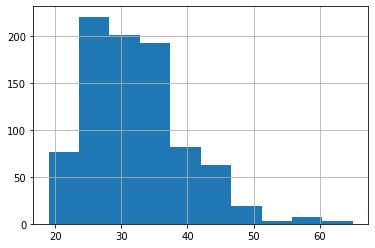

In [9]:
train_df['Age'].hist()

Now the spurious values in Age have been replaced with Null

### Gender
Collapsing gender into three main buckets

In [10]:

male = ['M', 'Male', 'male', 'm', 'maile',
       'Mal', 'Make', 'Male ', 'Man', 'msle', 'Mail', 
       'Malr','ostensibly male, unsure what that really means','Cis Male','Male (CIS)','cis male','Cis Man']
female = ['Female', 'female', 'F','Woman', 'f', 
          'Femake', 'woman', 'Female ', 
          'Female (cis)', 'femail','Cis Female','cis-female/femme']
other = ['Male-ish', 'Trans-female', 'something kinda male?',
       'queer/she/they','non-binary', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Androgyne', 'Agender',
        'Guy (-ish) ^_^', 'male leaning androgynous',
       'Trans woman',  'Neuter', 'Female (trans)',
       'queer', 'A little about you','p']

print(male in other)
print(female in other)
print(other in male)
print(other in female)

False
False
False
False


In [11]:
train_df.replace(male,"Male", inplace=True)
train_df.replace(female,"Female",inplace=True)
train_df.replace(other,"Other", inplace=True)
train_df['Gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [12]:
test_df.replace(male,"Male", inplace=True)
test_df.replace(female,"Female",inplace=True)
test_df.replace(other,"Other", inplace=True)
test_df['Gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

## Check for States, Countries

1. Only 9 values in US State are null. the rest of the null vlaues belong to other countries, where state info is not mentioned
2. State adds a lot of complexity in the data and details onoy for US. 
3. We will keep our business question specific to globe. Further cluster countries into continents

In [13]:

train_df[train_df['state'].isna()].groupby(by='Country', dropna=False).count()

,Timestamp,Age,Gender,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
Country,,,,,,,,,,,,,,,,,,,,,
Australia,17,17,17,0,17,17,17,16,17,17,...,17,17,17,17,17,17,17,17,17,3
Austria,2,2,2,0,2,2,2,1,2,2,...,2,2,2,2,2,2,2,2,2,0
Belgium,2,2,2,0,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,1
Bosnia and Herzegovina,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Brazil,2,2,2,0,2,2,2,1,2,2,...,2,2,2,2,2,2,2,2,2,0
Bulgaria,2,2,2,0,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
Canada,43,43,43,0,39,43,43,36,43,43,...,43,43,43,43,43,43,43,43,43,3
Colombia,2,2,2,0,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
Costa Rica,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,0


In [14]:
print(cc_df['Country'].unique())

N_America = ['United States', 'Canada', 'Bahamas, The']

L_America = ['Mexico', 'Brazil','Costa Rica','Colombia', 'Uruguay']

Europe = ['United Kingdom', 'Bulgaria', 'France',
       'Portugal', 'Netherlands', 'Switzerland', 'Poland', 
       'Germany', 'Russia', 'Slovenia', 
       'Austria', 'Ireland', 'Italy', 'Sweden','Latvia', 'Romania', 'Belgium', 
       'Spain', 'Finland', 
       'Bosnia and Herzegovina', 'Hungary', 'Croatia', 'Norway', 'Denmark',
       'Greece', 'Moldova', 
       'Czech Republic']

Asia = ['India', 'Israel','Singapore', 'Japan',
      'Thailand', 'Georgia', 'China','Philippines']

Australia = ['Australia','New Zealand']

Africa = ['Nigeria','South Africa','Zimbabwe']

['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines']


In [15]:
train_df['Continent'] = train_df['Country'].map(lambda x: "N_America" if(x in N_America) else ("L_America" if(x in L_America) else ("Europe" if (x in Europe) else ("Asia" if(x in Asia) else ("Australia" if(x in Australia) else ("Africa" if(x in Africa) else "Not Found")))) ))

In [16]:
train_df['Continent'].unique()

array(['N_America', 'Europe', 'Asia', 'Australia', 'Africa', 'L_America'],
      dtype=object)

In [17]:
test_df['Continent'] = test_df['Country'].map(lambda x: "N_America" if(x in N_America) else ("L_America" if(x in L_America) else ("Europe" if (x in Europe) else ("Asia" if(x in Asia) else ("Australia" if(x in Australia) else ("Africa" if(x in Africa) else "Not Found")))) ))
train_df['Continent'].unique()

array(['N_America', 'Europe', 'Asia', 'Australia', 'Africa', 'L_America'],
      dtype=object)

# Exploratory Data Analysis (Univariate and Multivariate Plots)

1. We will look at categorical and numeric plots starting with univariate plots.
2. Will start with first our variable of interest which is treatment

<AxesSubplot:ylabel='None'>

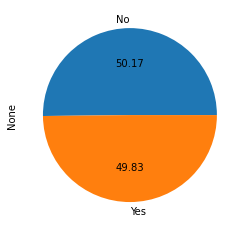

In [18]:
import matplotlib.pyplot as plt
# print(train_df.groupby('obs_consequence').count())
train_df.groupby('treatment').size().plot(kind='pie', autopct='%.2f')

1. We can see that the predictor variable is balanced

### Numerical Variable distribution

In [19]:
import altair as alt

alt.data_transformers.disable_max_rows()  # Allows us to plot big datasets

alt.Chart(train_df.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('treatment')
).properties(
    height=200
).repeat(
    train_df.select_dtypes('number').columns.to_list(),
    columns=2
)

alt.RepeatChart(...)

Age is the only continuous variable and exhibits near normal distribution and is somewhat the same for both target classes

In [20]:
train_df.select_dtypes('object').columns
categoricals = ['Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments', 'Continent']

In [21]:
alt.Chart(train_df.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='ordinal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment')
).properties(
    height=200
).repeat(
    categoricals,
    columns=1
)

alt.RepeatChart(...)

In [22]:
alt.Chart(train_df.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='ordinal'),
    alt.Y('count()', stack='normalize'),
    alt.Color('treatment')
).properties(
    height=200
).repeat(
    categoricals,
    columns=1
)

alt.RepeatChart(...)

1. The catgeorical variables need to be collapsed, especially the country. This is already done through collapsing continent. However still a major portion is from N_America and Europe.
2. Comments needs to be taken out since they are not available for most of the dataset
3. Some variables seem to form a good predcitors where the distribution of Yes and No is different for instance obs_consequence, leave, anonymity,care optuons etc.

In [23]:
for i in categoricals:
    print(pd.crosstab(train_df[i],train_df['treatment']))
    print('\n')

treatment   No  Yes
Gender             
Female      57  116
Male       381  310
Other        4   13


treatment                No  Yes
Country                         
Australia                 7   10
Austria                   2    0
Bahamas, The              0    1
Belgium                   2    0
Bosnia and Herzegovina    1    0
Brazil                    0    2
Bulgaria                  1    2
Canada                   21   22
Colombia                  2    0
Costa Rica                1    0
Croatia                   0    2
Czech Republic            1    0
Denmark                   0    1
Finland                   2    0
France                    9    1
Germany                  17   12
Greece                    2    0
Hungary                   1    0
India                     5    2
Ireland                  10   11
Israel                    5    0
Italy                     4    0
Japan                     0    1
Latvia                    1    0
Mexico                    1    1
Netherl

# Preparing the Data for pipelines

#### Separating the categoricals

In [24]:
categoricals_short_list = ['Gender', 'self_employed', 'family_history', 'treatment',
 'work_interfere',
 'no_employees',
 'remote_work',
 'tech_company',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'leave',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence',
 'Continent']



#### Imputing the ordinal categoricals

In [25]:
from sklearn.impute import SimpleImputer

ordinal_categorical = ['work_interfere', 'no_employees',  'leave','mental_health_consequence','phys_health_consequence','coworkers',
 'supervisor','mental_health_interview','phys_health_interview']

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_df[categoricals_short_list] =imputer.fit_transform(train_df[categoricals_short_list])

train_df[categoricals_short_list].isna().sum()



Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
Continent                    0
dtype: int64

In [26]:
test_df[categoricals_short_list] =imputer.transform(test_df[categoricals_short_list])

test_df[categoricals_short_list].isna().sum()

Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
Continent                    0
dtype: int64

### Ordinal Encoding of Ordered Catgeoricals
We will do this outside the pieline as it requires custom handling of ranks within the data

In [27]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_categorical = ['work_interfere', 'no_employees',  'leave','mental_health_consequence','phys_health_consequence','coworkers',
 'supervisor','mental_health_interview','phys_health_interview']

rating_order_workint = ['Never','Rarely','Sometimes','Often']
oe = OrdinalEncoder(categories = [rating_order_workint], dtype=int)
oe.fit(train_df[['work_interfere']])
train_df['work_interfere1'] = oe.transform(train_df[['work_interfere']])
train_df['work_interfere1'].unique()
test_df['work_interfere1'] = oe.transform(test_df[['work_interfere']])
test_df['work_interfere1'].unique()



rating_order_numemployee = ['1-5','6-25','26-100','100-500','500-1000','More than 1000']
oe = OrdinalEncoder(categories = [rating_order_numemployee], dtype=int)
oe.fit(train_df[['no_employees']])
train_df['no_employees1'] = oe.transform(train_df[['no_employees']])
train_df['no_employees1'].unique()
test_df['no_employees1'] = oe.transform(test_df[['no_employees']])
test_df['no_employees1'].unique()

rating_order_leave = ['Very easy','Somewhat easy',"Don't know",'Somewhat difficult','Very difficult']
oe = OrdinalEncoder(categories = [rating_order_leave], dtype=int)
oe.fit(train_df[['leave']])
train_df['leave1'] = oe.transform(train_df[['leave']])
train_df['leave1'].unique()
test_df['leave1'] = oe.transform(test_df[['leave']])
test_df['leave1'].unique()

rating_order_nomaybeyes = ['No', 'Maybe', 'Yes']
oe = OrdinalEncoder(categories = [rating_order_nomaybeyes], dtype=int)
oe.fit(train_df[['mental_health_consequence']])
train_df['mental_health_consequence1'] = oe.transform(train_df[['mental_health_consequence']])
test_df['mental_health_consequence1'] = oe.transform(test_df[['mental_health_consequence']])

oe.fit(train_df[['phys_health_consequence']])
train_df['phys_health_consequence1'] = oe.transform(train_df[['phys_health_consequence']])
test_df['phys_health_consequence1'] = oe.transform(test_df[['phys_health_consequence']])


rating_order_nosomeyes = ['No', 'Some of them', 'Yes']
oe = OrdinalEncoder(categories = [rating_order_nosomeyes], dtype=int)
oe.fit(train_df[['coworkers']])
train_df['coworkers1'] = oe.transform(train_df[['coworkers']])
test_df['coworkers1'] = oe.transform(test_df[['coworkers']])
train_df['coworkers'].unique()

oe = OrdinalEncoder(categories = [rating_order_nosomeyes], dtype=int)
oe.fit(train_df[['supervisor']])
train_df['supervisor1'] = oe.transform(train_df[['supervisor']])
test_df['supervisor1'] = oe.transform(test_df[['supervisor']])

oe = OrdinalEncoder(categories = [rating_order_nomaybeyes], dtype=int)
oe.fit(train_df[['mental_health_interview']])
train_df['mental_health_interview1'] = oe.transform(train_df[['mental_health_interview']])
test_df['mental_health_interview1'] = oe.transform(test_df[['mental_health_interview']])

oe.fit(train_df[['phys_health_interview']])
train_df['phys_health_interview1'] = oe.transform(train_df[['phys_health_interview']])
test_df['phys_health_interview1'] = oe.transform(test_df[['phys_health_interview']])



In [28]:
train_df_fin = train_df[['Age','Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere1', 'no_employees1', 
                        'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help',
                         'anonymity', 'leave1', 'mental_health_consequence1', 'phys_health_consequence1', 'coworkers1',
                        'supervisor1', 'mental_health_interview1', 'phys_health_interview1', 'mental_vs_physical',
                        'obs_consequence', 'Continent']]

test_df_fin = test_df[['Age','Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere1', 'no_employees1', 
                        'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help',
                         'anonymity', 'leave1', 'mental_health_consequence1', 'phys_health_consequence1', 'coworkers1',
                        'supervisor1', 'mental_health_interview1', 'phys_health_interview1', 'mental_vs_physical',
                        'obs_consequence', 'Continent']]

test_df_fin.isna().sum()


Age                           3
Gender                        0
self_employed                 0
family_history                0
treatment                     0
work_interfere1               0
no_employees1                 0
remote_work                   0
tech_company                  0
benefits                      0
care_options                  0
wellness_program              0
seek_help                     0
anonymity                     0
leave1                        0
mental_health_consequence1    0
phys_health_consequence1      0
coworkers1                    0
supervisor1                   0
mental_health_interview1      0
phys_health_interview1        0
mental_vs_physical            0
obs_consequence               0
Continent                     0
dtype: int64

#### Separating the nominal catgeorical for the pipeline

In [29]:
nominal_categorical = set(categoricals_short_list)- set(ordinal_categorical)
nominal_categorical = list(set(nominal_categorical) - set(['treatment']))
nominal_categorical

['self_employed',
 'care_options',
 'tech_company',
 'anonymity',
 'benefits',
 'obs_consequence',
 'Continent',
 'remote_work',
 'Gender',
 'family_history',
 'wellness_program',
 'mental_vs_physical',
 'seek_help']

In [30]:
numeric_features = ['Age']
numeric_features

['Age']

In [31]:
X_train = train_df_fin.drop(columns=['treatment'])
y_train = train_df_fin['treatment']

X_test = test_df_fin.drop(columns=['treatment'])
y_test = test_df_fin['treatment']

In [32]:
y_train.replace(["Yes","No"],[1,0], inplace=True)
y_train

949     1
854     0
658     1
1213    0
439     1
       ..
118     1
681     1
86      1
724     1
876     0
Name: treatment, Length: 881, dtype: int64

In [33]:
y_test.replace(["Yes","No"],[1,0], inplace=True)
y_test

788     0
271     1
323     1
143     0
1185    0
       ..
145     1
275     0
981     1
656     0
494     0
Name: treatment, Length: 378, dtype: int64

In [34]:
X_train

,Age,Gender,self_employed,family_history,work_interfere1,no_employees1,remote_work,tech_company,benefits,care_options,...,leave1,mental_health_consequence1,phys_health_consequence1,coworkers1,supervisor1,mental_health_interview1,phys_health_interview1,mental_vs_physical,obs_consequence,Continent
949,40.00,Male,No,Yes,2,1,No,Yes,Yes,Yes,...,0,1,0,1,1,0,0,Don't know,No,N_America
854,31.00,Male,No,Yes,2,1,No,Yes,Don't know,Not sure,...,2,1,0,1,1,0,0,Don't know,No,N_America
658,30.00,Male,No,Yes,2,5,No,Yes,Yes,Yes,...,2,1,0,1,2,0,2,Yes,No,Europe
1213,31.00,Male,No,No,2,5,No,Yes,Don't know,No,...,4,2,2,1,0,0,1,No,Yes,Asia
439,29.00,Male,No,Yes,1,0,Yes,Yes,Yes,Yes,...,1,0,0,2,2,1,1,Yes,No,N_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,NaN,Male,No,No,1,0,Yes,Yes,No,No,...,0,0,0,1,0,0,0,Don't know,No,N_America
681,38.00,Male,No,No,2,5,No,No,Yes,Yes,...,2,0,0,1,2,0,0,Don't know,No,N_America
86,39.00,Male,Yes,No,3,1,No,Yes,No,No,...,4,1,0,1,0,0,1,No,Yes,Europe
724,33.00,Male,No,Yes,2,0,No,No,No,Yes,...,2,0,0,1,2,1,1,Don't know,No,N_America


### Building preprocessor pipeline for onehotencoding and imputing and standardization of Age/Numeric

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop='if_binary')
)

col_transformer = make_column_transformer(
    (numeric_transformer, numeric_features), 
    (categorical_transformer, nominal_categorical),
    remainder='passthrough'
)

### Pipeline for Dummy Classifaction - Base Model

In [36]:
from sklearn.dummy import DummyClassifier

dummy_pipe = make_pipeline(col_transformer, DummyClassifier())
dummy_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                

In [37]:
from sklearn.model_selection import cross_validate

dummy_pipe.fit(X_train, y_train)
print(dummy_pipe.score(X_train, y_train))

dummy_scores_df = pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, cv=5,return_train_score=True, scoring = ['accuracy','f1','recall','precision'] ))

dummy_scores_df

0.5017026106696936


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.02,0.01,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00
1,0.02,0.01,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00
2,0.01,0.01,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00
3,0.01,0.01,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00
4,0.01,0.01,0.51,0.50,0.00,0.00,0.00,0.00,0.00,0.00


### Findings
1. Base Model Accuracy is 50%, however f1 score is poor due to poor recall and precision

# Building Pipeline to maximize recall through different algorithms

### SVC

In [38]:
pipe = make_pipeline(col_transformer, SVC())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                

In [39]:
param_grid = {
    "svc__gamma": [0.0001, 0.001,0.01,0.1, 1.0, 10, 100],
    "svc__C": [0.1, 1.0, 10, 100,1000]
}


In [40]:
from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(pipe, param_grid, cv=3, verbose=2, n_jobs=-1, return_train_score=True,random_state=289,scoring = 'recall')
random_search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [41]:
pd.DataFrame(random_search.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score', ascending=True)

,params,mean_test_score,mean_train_score,rank_test_score
1,"{'svc__gamma': 0.0001, 'svc__C': 1000}",0.71,0.74,1
9,"{'svc__gamma': 0.1, 'svc__C': 1.0}",0.69,0.90,2
0,"{'svc__gamma': 0.1, 'svc__C': 1000}",0.64,1.00,3
6,"{'svc__gamma': 0.1, 'svc__C': 100}",0.64,1.00,3
8,"{'svc__gamma': 1.0, 'svc__C': 100}",0.55,1.00,5
2,"{'svc__gamma': 10, 'svc__C': 100}",0.00,1.00,6
3,"{'svc__gamma': 10, 'svc__C': 1.0}",0.00,1.00,6
7,"{'svc__gamma': 10, 'svc__C': 10}",0.00,1.00,6
4,"{'svc__gamma': 10, 'svc__C': 0.1}",0.00,0.00,9
5,"{'svc__gamma': 0.0001, 'svc__C': 1.0}",0.00,0.00,9


In [42]:
random_search.best_params_

{'svc__gamma': 0.0001, 'svc__C': 1000}

In [43]:
from sklearn.metrics import confusion_matrix



predictions = random_search.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cm

array([[139,  41],
       [ 62, 136]], dtype=int64)

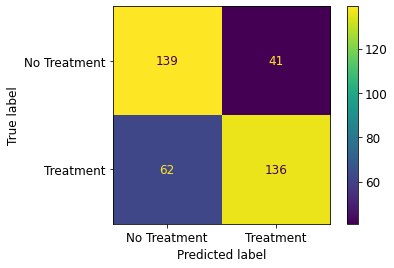

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm, display_labels=["No Treatment", "Treatment"]).plot()

In [45]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_test,
        random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
)

              precision    recall  f1-score   support

no treatment       0.69      0.77      0.73       180
   treatment       0.77      0.69      0.73       198

    accuracy                           0.73       378
   macro avg       0.73      0.73      0.73       378
weighted avg       0.73      0.73      0.73       378



In [46]:
from sklearn.linear_model import LogisticRegression

pipe_logis = make_pipeline(col_transformer,LogisticRegression(random_state=123,max_iter=1000))

In [47]:
scores = cross_validate(
    pipe_logis,
    X_train,
    y_train,
    return_train_score=True, scoring = 'recall'
)

pd.DataFrame(scores).mean()

fit_time      0.06
score_time    0.01
test_score    0.71
train_score   0.75
dtype: float64

In [48]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_backward = make_pipeline(
    col_transformer,
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        direction='backward',
        n_features_to_select=5,
        n_jobs=-1
    ),
    LogisticRegression(max_iter=1000)
)

In [49]:
scores = cross_validate(
    pipe_backward, X_train, y_train, 
    return_train_score=True, scoring = 'recall'
)
pd.DataFrame(scores).mean()

fit_time      37.00
score_time     0.01
test_score     0.74
train_score    0.74
dtype: float64

In [53]:
pipe_backward.fit(X_train,y_train)

predictions = pipe_backward.predict(X_test)

cm = confusion_matrix(y_test, predictions)
cm

array([[130,  50],
       [ 64, 134]], dtype=int64)

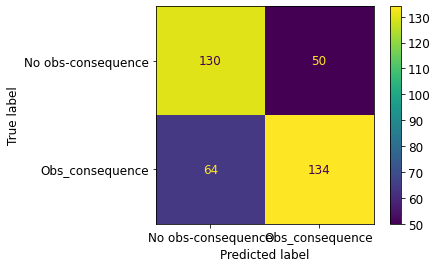

In [54]:
plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm, display_labels=["No treatment", "Treatment"]).plot()

In [55]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_test,
        pipe_backward.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
)

              precision    recall  f1-score   support

no treatment       0.67      0.72      0.70       180
   treatment       0.73      0.68      0.70       198

    accuracy                           0.70       378
   macro avg       0.70      0.70      0.70       378
weighted avg       0.70      0.70      0.70       378



In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(col_transformer, KNeighborsClassifier(n_neighbors = 2, weights = 'distance'))
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                

In [57]:
scores = cross_validate(
    knn_pipe, X_train, y_train, 
    return_train_score=True, scoring = 'recall'
)
pd.DataFrame(scores).mean()

fit_time      0.03
score_time    0.02
test_score    0.57
train_score   1.00
dtype: float64

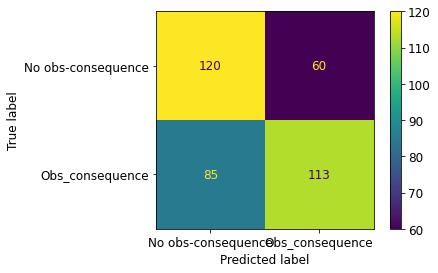

In [58]:
knn_pipe.fit(X_train,y_train)

predictions = knn_pipe.predict(X_test)

cm = confusion_matrix(y_test, predictions)
plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm, display_labels=["No obs-consequence", "Obs_consequence"]).plot()